# Imports


In [1]:
import numpy as np
import datetime
import pandas as pd
import math
from GMM import GMM
import matplotlib.pyplot as plt
from comparator import ComparatorWithImpostor, Comparator
from cross_validation import CrossValidation
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from scipy.stats import multivariate_normal

# Load data

In [2]:
target_frame_sanderson = pd.read_csv('data/feature.csv')

In [3]:
target_frame_sanderson.fillna(0, inplace=True)
target_frame_sanderson.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,5751,5752,5753,5754,5755,5756,5757,5758,5759,5760
0,0,22.0,1.188545,-0.801189,2.747025,0.805634,0.134741,-1.725609,0.566560,-3.178878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,15.0,2.475573,1.875510,2.825408,0.459833,3.859801,3.000709,0.740427,3.369751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,17.0,1.636064,1.690520,4.934273,0.016624,-0.253265,0.045444,3.057260,2.570395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,35.0,1.598943,0.802135,3.414424,4.703372,4.032905,-0.851257,0.847020,-1.325417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,19.0,1.356942,0.835537,3.458208,1.058637,0.854547,-0.125851,-1.312550,-0.872325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
y = target_frame_sanderson.iloc[:, 1]
X = target_frame_sanderson.iloc[:, 2:].values
y.head()

0    22.0
1    15.0
2    17.0
3    35.0
4    19.0
Name: 0, dtype: float64

In [5]:
StratifiedShuffleSplit(n_splits=3, test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
df_y = pd.DataFrame(y_train)
df_x = pd.DataFrame(X_train)
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,5750,5751,5752,5753,5754,5755,5756,5757,5758,5759
0,1.188545,-0.801189,2.747025,0.805634,0.134741,-1.725609,0.566560,-3.178878,3.605380,4.542037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.475573,1.875510,2.825408,0.459833,3.859801,3.000709,0.740427,3.369751,2.688438,-2.744781,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.636064,1.690520,4.934273,0.016624,-0.253265,0.045444,3.057260,2.570395,2.955720,-1.238426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.598943,0.802135,3.414424,4.703372,4.032905,-0.851257,0.847020,-1.325417,1.439255,2.180452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.356942,0.835537,3.458208,1.058637,0.854547,-0.125851,-1.312550,-0.872325,-0.735106,0.813669,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
arr1 = df_x.values[0]
arr1 = np.trim_zeros(arr1)
arr1

array([ 1.18854509, -0.80118914,  2.74702471, ..., -5.38357079,
       -2.53144843, -3.41670447])

# Prepare data

In [7]:
import random
from sklearn.decomposition import PCA

test_size = 0.3

def group_by_data(data, tar):

    def get_key(t):
        return t[1]

    res = list(zip(data, tar))
    res = sorted(res, key=get_key)
    data, tar = list(zip(*res))

    d = []
    t = []
    init = 0
    step = 10

    for idx in range(0, 42):
        d.append(data[init:init+step])
        t.append(tar[init:init + step])
        init += step

    return np.array(d), np.array(t)

def decomposer(data):
    return PCA(n_components=100).fit_transform(data)

def split_data(data, tar):
    dataset, target = group_by_data(data, tar)

    filtered = []
    for data1 in dataset:
        aux = []
        for d in data1:
            d = d[d != 0]
            d = d[0:1000]
            aux.append(d)
        filtered.append(aux)
    dataset = np.array(filtered)

    #
    # dataset = [self.decomposer(d) for d in dataset]

    n_interaction = [round(len(d) * test_size) for d in dataset]

    data_tes = []
    target_tes = []
    data_train = []
    target_train = []
    for d in range(0, len(dataset)):
        for i in range(0, n_interaction[d]):
            rand_i = random.randint(0, len(dataset[d]) - 1)
            data_tes.append(dataset[d][rand_i])
            target_tes.append(target[d][rand_i])
            new_dataset = np.delete(dataset[d], rand_i, axis=0)
            new_target = np.delete(target[d], rand_i, axis=0)
        data_train.append(new_dataset)
        target_train.append(new_target)
    return data_train, target_train, data_tes, target_tes


In [30]:
X_train, X_test, y_train, y_test = split_data(X, y)
data_train = X_train[0]
X_train[0]

array([[ 2.60114136,  0.24675656,  0.79888349, ..., -0.42146225,
         2.2665716 , -0.84737929],
       [ 2.16077182,  0.54589239,  1.66954544, ...,  1.01614994,
         1.19552415,  0.68081875],
       [ 1.83855252, -0.3039092 ,  4.65539437, ...,  0.47067346,
         5.12435885,  3.48850433],
       ..., 
       [ 1.88174053,  0.79902863,  3.98940539, ...,  1.08795015,
         1.31818976, -1.7476976 ],
       [ 1.89926456, -0.19796892,  3.70001775, ...,  0.60919483,
         2.70841674, -0.32295807],
       [ 1.73370578,  0.86760022,  4.56155718, ...,  1.06011415,
         1.03084308,  0.6989374 ]])

# Calc Kmeans 

In [47]:
import numpy as np
import random
from numpy import linalg as LA
import matplotlib.pyplot as plt


class KMeans:

    def __init__(self, number_of_gaussians, max_interation=10):
        self.Ng = number_of_gaussians
        self.max_interation = max_interation

    def __min_norm_gauss(self, mu, Xi):
        norms = [LA.norm(mu[g] - Xi) for g in range(0, self.Ng)]
        return norms.index(min(norms))

    def __min_index_gauss(self, mu, data):
        return [self.__min_norm_gauss(mu, data[i]) for i in range(0, len(data))]

    def __means(self, X):
        def __new_mu(data, delta_kronecker):
            gf = [delta_kronecker(i) for i in range(0, len(data))]
            if sum(gf) == 0:
                return 0, np.zeros(len(data[0]))
            mu_updated = (1 / sum(gf)) * sum([data[ix] * y for ix, y in enumerate(gf)])
            return sum(gf), mu_updated

        mu = [random.choice(X) for i in range(0, self.Ng)]

        loop = 1
        finished = False
        yi = []
        ng = []
        while not finished:
            yi = self.__min_index_gauss(mu, X)
            res = [__new_mu(X, lambda ix: yi[ix] == g) for g in range(0, self.Ng)]
            ng, mu_new = zip(*res)
            ng = list(ng)
            mu_new = list(mu_new)

            same = all([np.array_equal(mu[g], mu_new[g]) for g in range(0, self.Ng)])
            loop = loop + 1
            finished = same or loop > self.max_interation

            mu = mu_new
        return ng, mu, yi

    def exec(self, data):
        print("Data length: %d" % len(data))
        def safe_div(x, y):
            if y == 0:
                return 0
            return x / y

        ng, mu, y = self.__means(data)
        mg = [ng[g] / len(data) for g in range(0, self.Ng)]
        
        print("Ng:")
        print(ng)
        print("Mu:")
        print(mu[0][1:10])
        print(len(mu[0]))
        print(len(X))
        print("Mg:")
        print(mg)

        sigmas = []
        for g in range(0, self.Ng):
            acc = []
            for i in range(0, len(data)):
                s = np.outer(data[i] - mu[g], data[i] - mu[g]) * (y[i] == g)
                acc.append(s)
            r = safe_div(1, ng[g]) * sum(acc)
            sigmas.append(r)

        sigmas = [safe_div(1, ng[g]) * np.cov((data - mu[g]).T) * np.identity(len(data[0])) for g in range(0, self.Ng)]
        sigmas = np.array(sigmas)
        print("Sigmas:")
        print(sigmas)


        return mg, mu, sigmas


In [48]:
kmeans = KMeans(3)
lamb = kmeans.exec(data_train)
mg, mu, sigmas = lamb

Data length: 9
Ng:
[5, 2, 2]
Mu:
[ 0.82085396  2.74262231 -0.14064496  0.53572302  0.70269656 -2.5872265
 -3.12246259 -1.26295348 -2.09138089]
1000
420
Mg:
[0.5555555555555556, 0.2222222222222222, 0.2222222222222222]
Sigmas:
[[[ 0.05920956 -0.         -0.         ...,  0.         -0.         -0.        ]
  [-0.          0.16766332  0.         ...,  0.         -0.          0.        ]
  [-0.          0.          0.35784369 ...,  0.          0.          0.        ]
  ..., 
  [ 0.          0.          0.         ...,  0.24680918 -0.          0.        ]
  [-0.         -0.          0.         ..., -0.          1.07983149  0.        ]
  [-0.          0.          0.         ...,  0.          0.          0.80518753]]

 [[ 0.14802389 -0.         -0.         ...,  0.         -0.         -0.        ]
  [-0.          0.41915831  0.         ...,  0.         -0.          0.        ]
  [-0.          0.          0.89460922 ...,  0.          0.          0.        ]
  ..., 
  [ 0.          0.          

In [66]:
class Util:

    def __init__(self, number_of_gaussians):
        self.Ng = number_of_gaussians


    def gauss(self, x, u, e):
        e += 0.0001 * np.identity(len(e))
        # try:
        #     print('Deter %d ' % np.linalg.det(e))
        # except:
        #     print(e)

        pdf1 = multivariate_normal(u, e).pdf(x)
        #pdf2 = self.gaussian_pdf(u, e, x)
        print(pdf1)

        return pdf2

        # res = multivariate_normal(u, e)
        # return res.pdf(x)

    def gaussian_pdf(self, u, e, x):
        
        p2 = np.outer(x - u, x - u)
        p1 = (x - u).T.dot((x - u))
        aux2 = np.exp(-1/2 * p1)
        aux1 = 1 / ((2*np.pi) ** 3/2)
        print("aux1")
        print(aux1)
        print("aux2")
        print(aux2)
        return aux1 * aux2


    def weighted_gauss(self, x, m, u, e):
        return m * self.gauss(x, u, e)

    def sum_weighted_gauss(self, x, lamb):
        acc = []
        for g in range(0, self.Ng):
            m_arr = lamb[0]
            u_arr = lamb[1]
            e_arr = lamb[2]

            acc.append(self.weighted_gauss(x, m_arr[g], u_arr[g], e_arr[g]))
        return sum(acc)

    def get_prob(self, data, lamb):
        acc = []
        for i in range(0, len(data)):
            w = self.sum_weighted_gauss(data[i], lamb)
            print(w)
            acc.append(w)
        return sum(acc)

    def get_prob_log(self, data, lamb):
        acc = []
        for i in range(0, len(data)):
            acc.append(math.log(self.sum_weighted_gauss(data[i], lamb)))
        return sum(acc)

# EM - Expectation Maximization

In [67]:
Ng = 3
max_interation = 10
utils = Util(3)

def __maximum_likelihood(X, lamb):
    for i in range(0, max_interation):
        p_old = utils.get_prob_log(X, lamb)
        lamb_new = __expectation_maximisation(X, lamb)
        p_new = self.utils.get_prob_log(X, lamb_new)
        if p_new > p_old:
            lamb = lamb_new
    return lamb

def calc_lg(data, lamb, g):
    for i in range(0, len(data)):
        aux1 = utils.weighted_gauss(data[i], lamb[0][g], lamb[1][g], lamb[2][g])
        aux2 = utils.sum_weighted_gauss(data[i], lamb)
        yield aux1 / aux2

def __expectation_maximisation(X, lam):

    def ug_concat(x, lg_aux): return [x[i] * lg_aux[i] for i in range(0, len(x))]

    def safe_div(x, y):
        if y == 0:
            return 0
        return x / y

    lgi = [list(calc_lg(X, lam, g)) for g in range(0, Ng)]
    lg = [sum(lgi[g]) for g in range(0, Ng)]

    weight = [lg[g] / len(X) for g in range(0, Ng)]
    mu = [(safe_div(1, lg[g]) * sum(ug_concat(X, lgi[g]))) for g in range(0, Ng)]
    sigmas = []
    for g in range(0, Ng):
        acc = []
        for i in range(0, len(X)):
            s = np.outer(X[i], X[i]) * lgi[g][i]
            acc.append(s)
        r = safe_div(1, lg[g]) * sum(acc) - np.outer(mu[g], mu[g])
        sigmas.append(r)


    sigma = [np.cov((X - mu[g]).T) for g in range(0, Ng)]

    return weight, mu, sigmas

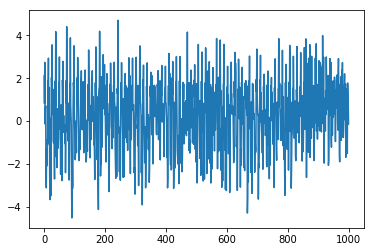

In [78]:
x_axis = np.linspace(0, len(lamb[1]), 1)
plt.plot(lamb[1][0])
plt.show()

In [68]:
utils.get_prob(data_train, lamb)
#__maximum_likelihood(arr1, lamb)

aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
aux1
0.008062883608299874
aux2
0.0
0.0
0.0
aux1
0.008062883608299874
aux2
0

0.0